# Predictive coding of an $M$-dimensional signal in an $N$-dimensional network

Here, we derive and simulate dynamical equations for an N-dimensional network of neurons based on the derivations from the single neuron [1].

## Vectorizing the differential equations

Vectorizing the readout differential equation leads to

\begin{align}
    \dot{y}(t) = - y(t) + \textbf{D}^T\textbf{o}(t),  
\end{align}

where changes in $y(t)$ depend on the scalar product of a row vector $\textbf{D}^T = \frac{1}{N}(D_1, D_2, ..., D_N)$ and column vector $\textbf{o}(t)$ describing each neuron's spike train.

In [5]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
from numpy import linalg as LA
#from cmaps import nice_cmap
from matplotlib.legend_handler import HandlerLine2D
import math
%matplotlib inline

" Parameters/containers "
VERBOSE = False                     # Printout
N       = 16                        # Number of neurons
M       = 2                         # Number of signal dimensions

T       = 100                      # Total duration
dt      = 0.001                     # Integration time step
time    = np.arange(0, T, dt)       # Time array
V       = np.zeros((N,len(time)))   # Membrane voltage
a       = 1.                        # Input amplitude
x       = np.zeros((M,len(time)))   # Constant input
x[0,:]  = np.cos(time)
x[1,:]  = np.sin(time)
x[0,0]  = 0
x[1,0]  = 0
x       *= 5
#x      += a*rand.normal(0.0,0.01,(M,len(time))) ## Adding white noise
#x       = np.abs(x) 
y       = np.zeros((M,len(time)))   # Decoder
o       = np.zeros((N,len(time)))   # Spikes
st      = []                        # Spike times + index
rate    = np.zeros((N,len(time)))   # Firing rate
mu      = 0.000000                    # Regularization constant (e-7)
#D       = 0.1*np.ones((M,N))/N      # Random readout weights (normally distributed)
inh     = int(1.1*N)
#D[inh:] = -1. * D[inh:]
#D       = 0.1*rand.normal(.0, 1., (M,N))#/N
Dsigma  = 0.0
angles  = np.linspace(0, 2*np.pi, num=N, endpoint=False) # + weight_noise*rand.normal(0.0,1.0, N)
Dlen    = 1 #*(weight_noise*rand.normal(0.0,1.0, N)+1.0)
D       = Dlen*np.array([np.cos(angles),np.sin(angles)])
D0      = Dlen*np.array([np.cos(angles),np.sin(angles)])
W       = (D.T).dot(D) + mu*np.eye(N)
if VERBOSE:
    evals, evecs = LA.eigh(W)
    print("Recurrent weights:", W)
    print("Readout weights:", D)
    print("Spectral radius:", evals)
Thr     = np.diag((D.T).dot(D))/2 + (mu/2)*np.ones(N)      # Threshold
decay   = 1.                        # Decay constant
V[:,0]  = -Thr
if VERBOSE:
    print("Threshold:", Thr)

" Ablations "
ast = T/4
ablate_t= (np.arange(ast,ast+1.0,0.25))/dt
#if VERBOSE:
print("Ablations at t=", ablate_t*dt ,"secs.")
ablate_t=ablate_t.astype(int)
ablate_t = []
ablated = []
to_ablate = []

" Voltage ODE "
def dV(i, spike):
    return - V[:,i] + (D.T).dot((x[:,i]+(x[:,i+1]-x[:,i])/dt)) - W.dot(spike)/dt

" Decoder ODE "
def dy(i, spike):
    return - y[:,i] + D.dot(spike)/dt
" Rate ODE "
def dr(i, spike):
    return - rate[:,i] + spike/dt

" List difference function "
def diff(a):
    return [a[i+1]-a[i] for i in range(len(a)-1)]

" Randomly choose one spike "
def rand_one(array):
    return rand.choice(np.ravel(np.nonzero(array)), 1)[0]

" Ablate i-th neuron at time step ts "
def ablate_neuron(i, ts):
    print("Ablate neuron", i)
    ablated.append(i)
    D[:,i]  = 0
    W[:,:]  = (D.T).dot(D) + mu*np.eye(N)
    W[i,i]  = 0 
    V[i,ts:] = 0. 

" Update step "
def step(i):
    if np.sum(o[:,i] > 0):
        st.append(t)
    " Potential (Euler) "
    V[:,i+1] = V[:,i] + dt * dV(i, o[:,i])   
    " Check spikes "    
    o[:,i+1] = (V[:,i+1] > Thr)
    if np.sum(o[:,i+1])>0:
        specfl = rand_one(o[:,i+1])
        o[:, i+1] = np.eye(N)[specfl]
    " Decoder (Euler) "
    y[:,i+1] = y[:,i] + dt * dy(i, o[:,i+1])
    " Estimate firing rate (Euler) "
    rate[:,i+1] = rate[:,i] + dt * dr(i, o[:,i+1])
    
" Simulation "
for i,t in enumerate(time[:-1]):
    if math.fmod(t,T/10)==0:
        print("t:",t)
    ### Ablate three random neurons
    for ind, times in enumerate(ablate_t):
        if i == times:
            if len(to_ablate)==0:
                rand_neuron = rand.randint(N)
                while rand_neuron in ablated:
                    rand_neuron = rand.randint(N)
            else:
                if ind < len(to_ablate): 
                    rand_neuron = to_ablate[ind]
            if rand_neuron not in ablated:
                ablate_neuron(rand_neuron,i)
        
    step(i)
    if np.sum(o[:,i])>0 and VERBOSE:
        print("Spike time:", t, "@neuron", np.argmax(o[:,i])+1, np.sum(o[:,i]))
print("Spikes/time:", np.sum(o, axis=1)/(T))
print("Mean inverse ISI:", 1./(N*np.mean(diff(st))))


Ablations at t= [ 25.    25.25  25.5   25.75] secs.
t: 0.0
t: 10.0
t: 20.0
t: 30.0
t: 40.0
t: 50.0
t: 60.0
t: 70.0
t: 80.0
t: 90.0
Spikes/time: [ 0.43  0.61  0.45  0.35  0.51  0.53  0.44  0.49  0.52  0.45  0.48  0.49
  0.41  0.51  0.52  0.47]
Mean inverse ISI: 0.478756959186


(2, 16)


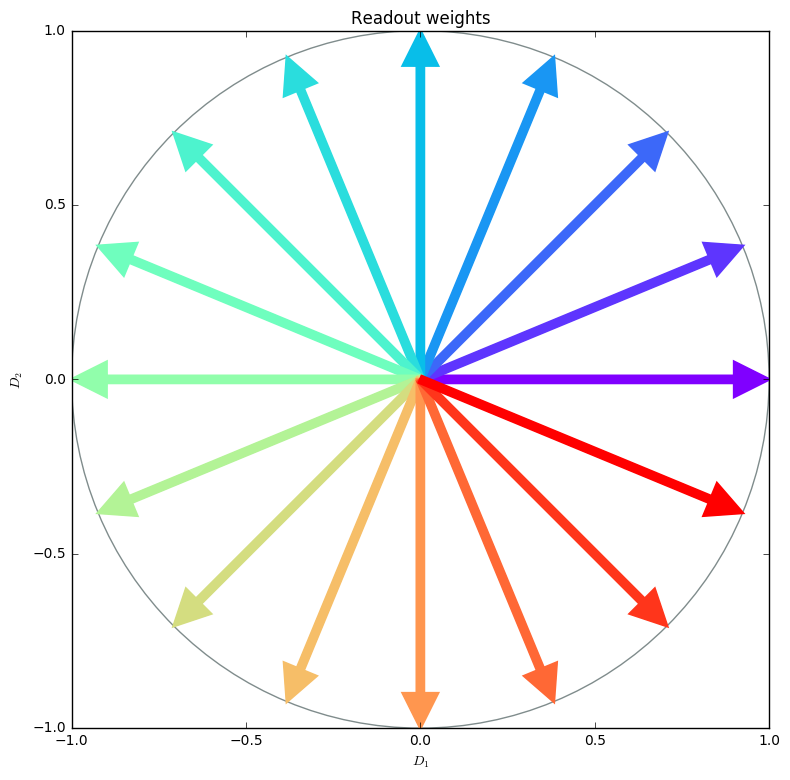

In [6]:
from matplotlib.patches import Circle, PathPatch
fig, ax = plt.subplots(figsize=(9, 9))
rmax = np.max(np.sqrt(D[0,:]**2+D[1,:]**2))
circle = Circle((0, 0), rmax, facecolor='none',
                edgecolor=(0, 0.1, 0.1), linewidth=1, alpha=0.5)
ax.add_patch(circle)
col = plt.get_cmap('rainbow', N)
print(D.shape)
arrow_sc= 0.1
for i in range(N):
    if np.sqrt(D[0,i]**2 + D[1,i]**2) > 0.:
        ax.arrow(0, 0, D[0,i], D[1,i], width=rmax*arrow_sc/5, head_width=rmax*arrow_sc, head_length=rmax*arrow_sc, lw=2, length_includes_head=True, fc=col(i), ec=col(i))
    ax.arrow(0, 0, D0[0,i], D0[1,i], width=rmax*arrow_sc/5, head_width=rmax*arrow_sc, head_length=rmax*arrow_sc, linestyle="--", lw=1, length_includes_head=True, facecolor='none', ec=col(i))

plt.xlim([-rmax,rmax])
plt.ylim([-rmax,rmax])
plt.xlabel("$D_1$")
plt.ylabel("$D_2$")
plt.title("Readout weights")
plt.show()

In [7]:
" Plotting "
def plot_fig1():
    npanels = 4
    f, axarr = plt.subplots(npanels, sharex=True)
    K=3
    drawN = N
    lcols = int(math.ceil(drawN/3))
    Rsize = K*drawN+1
    excV = plt.get_cmap('Reds', int(0.8*Rsize))
    inhV = plt.get_cmap('Blues', int(0.2*Rsize))
    excR = plt.get_cmap('autumn', int(0.8*Rsize))
    inhR = plt.get_cmap('winter', int(0.2*Rsize))
    f.set_figheight(npanels*2)
    f.set_figwidth(npanels*3)
    plt.xticks(np.arange(0,T+T/10,T/10))

    " Panel A: Decoding signal"
    for m in range(M):
        axarr[0].plot(time, x[m,:], c='k', label = 'Signal $x(t)$')
        axarr[0].plot(time, y[m,:], c='r', label ='Decoder $y(t)$')
    axarr[0].set_ylabel("Signal")
    #axarr[0].set_ylim([-0.1, a+0.1])
    axarr[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    " Panel B: Membrane potentials "
    for neuron in range(drawN):
        name = '$V_{'+str(neuron+1)+'}$'
        if neuron <= inh:
            axarr[1].plot(time, V[neuron,:], color=col(neuron), label = name)
        #else:
            #axarr[1].plot(time, V[neuron,:], color=inhV(Rsize-K*neuron), label = name)
    axarr[1].set_ylabel("Membrane potential")
    axarr[1].plot([0,T],[Thr,Thr], color='#bbbbbb')
    #axarr[1].set_ylim([-0.001, 0.002])
    #axarr[1].legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=lcols, borderaxespad=0.)

    " Panel C: Spike raster plot "
    npablated = np.array(ablated)
    for neuron in range(N):
        name = 'Neuron '+str(neuron+1)
        posy = (1+neuron)*o[neuron, o[neuron,:]==1]
        axarr[2].vlines(time[o[neuron,:]==1], posy-0.5, posy+0.5, label = name)
        if neuron in ablated:
            this_neuron = np.where(npablated==neuron)[0]
            axarr[2].plot(dt*ablate_t[this_neuron],neuron+1,'rx', mew=3, ms=8)
        #axarr[2].legend(handler_map={spikes: HandlerLine2D(numpoints=1)})
    #axarr[2].legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=lcols, borderaxespad=0.)
    axarr[2].set_ylim([0, N+1])
    axarr[2].set_ylabel("Neuron index")
    spacer = int(N/10)
    if spacer==0:
        spacer = 1
    axarr[2].set_yticks(np.arange(spacer,N+1,spacer))

    " Panel D: Firing rate estimates "
    for neuron in range(drawN):
        name = '$r_{'+str(neuron+1)+'}$'
        if neuron <= inh:
            axarr[3].plot(time, rate[neuron,:], color=col(neuron), label = name)
        #else:
            #axarr[3].plot(time, rate[neuron,:], color=inhR(K*neuron+10), label = name)
    axarr[3].set_ylabel("Firing rate")
    #axarr[3].legend(bbox_to_anchor=(1.05, 1), loc=2, ncol=lcols, borderaxespad=0.)
    #axarr[3].set_ylim([-1, 25.000])
    plt.xlabel("Time")
    
    return f, axarr

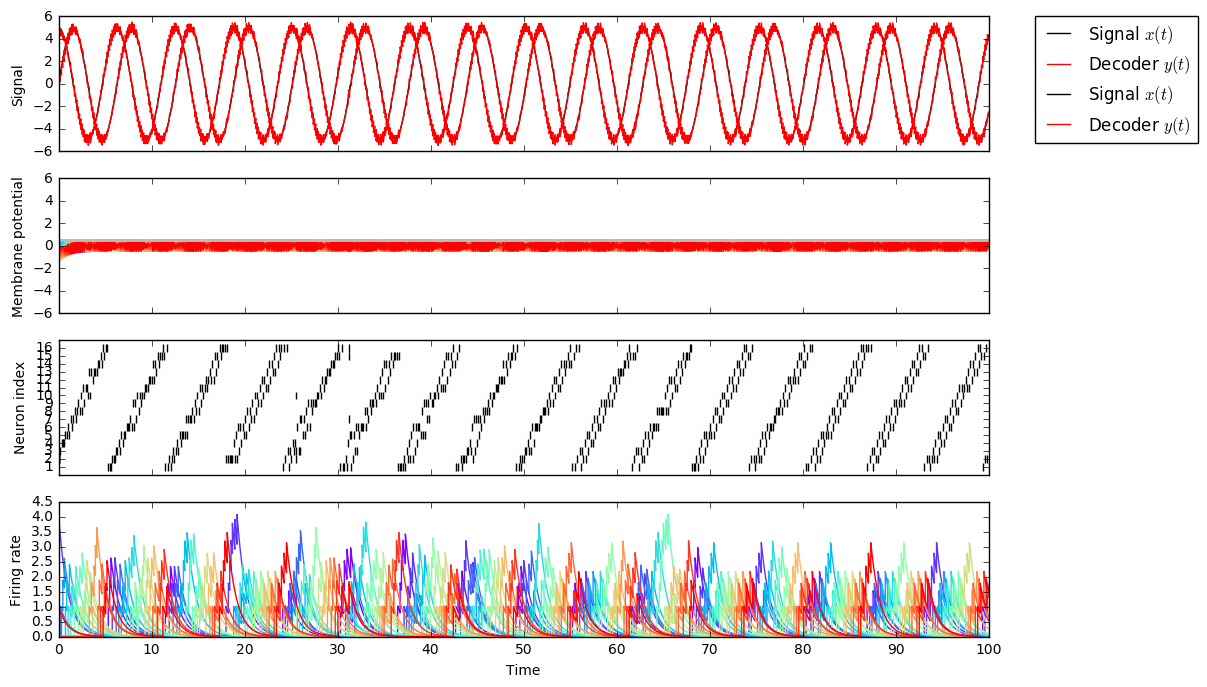

In [8]:
f, ax = plot_fig1()
#plt.xlim([0,1])
plt.show()

(2, 10000)
[   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15
   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30
   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45
   46   47   48   49   50   70   71  149  150  227  238  302  352  376  472
  473  589  590  658  659  726  739  793  891  892  987  988 1051 1059 1113
 1236 1237 1296 1297 1356 1473 1474 1531 1532 1589 1702 1703 1758 1840 1841
 1923 1924 1977 2084 2085 2137 2242 2243 2294 2397 2398 2448 2549 2550 2600
 2699 2700 2749 2847 2945 2946 2993 3090 3091 3138 3233 3328 3329 3375 3468
 3562 3563 3608 3609 3655 3656 3701 3793 3885 3886 3930 3931 3976 3977 4022
 4112 4203 4293 4383 4384 4429 4430 4474 4475 4519 4520 4564 4565 4608 4698
 4788 4877 4967 5056 5146 5235 5325 5326 5370 5371 5415 5416 5460 5461 5505
 5506 5550 5640 5731 5821 5912 5913 5958 5959 6004 6005 6050 6142 6234 6235
 6281 6282 6327 6328 6374 6467 6562 6563 6609 6704 6800 6801 6848 6945 7042
 

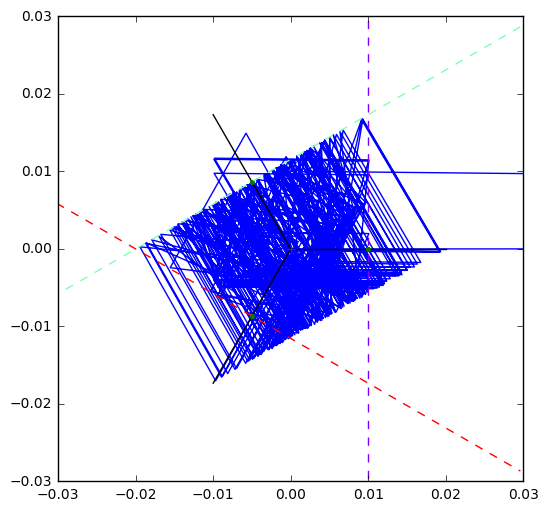

In [203]:
error = (x-y)
print(error.shape)
plt.figure(figsize=(6,6))
start_index = 0#29950
end_index = -1#30150
spikes = np.sum(o[:,start_index:end_index],axis=0)
print(np.where(spikes>0)[0]+start_index)
plt.plot(error[0,start_index:end_index],error[1,start_index:end_index], 'b-')
plt.plot([])

ortho = np.array([[0, -1],
                  [1,  0]])
w = 0.02*np.array( [[np.cos(2*np.pi*i/N)for i in range(N)], [np.sin(2*np.pi*i/N)for i in range(N)]] )
threshold = 0.5*w

orth_thr = 4.*ortho.dot(threshold)
linex = np.array([threshold[0,:]-orth_thr[0,:],threshold[0,:]+orth_thr[0,:]])
liney = np.array([threshold[1,:]-orth_thr[1,:],threshold[1,:]+orth_thr[1,:]])
print(line)

for i in range(N):
    plt.plot([0, w[0,i]],[0, w[1,i]],'k-')
    plt.plot(threshold[0,i],threshold[1,i],'g.')
    plt.plot(threshold[0,i],threshold[1,i],'g.')
    plt.plot(linex[:,i], liney[:,i], '--', c=col(i))
plt.plot(0,0,'r+')

plt.xlim([-0.03,0.03])
plt.ylim([-0.03,0.03])
plt.show()

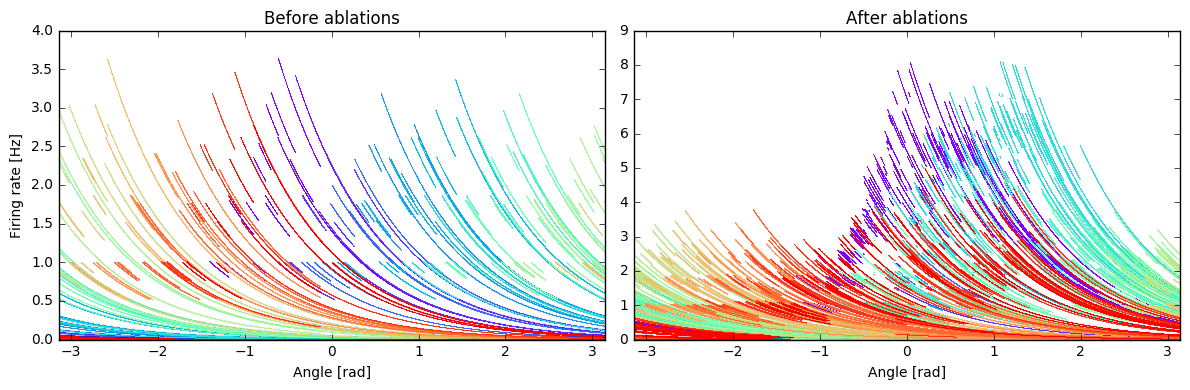

In [31]:
f, ax = plt.subplots(1,2)
f.set_figheight(4)
f.set_figwidth(12)
    
steady_t = int(0.0/dt)
end_t = int(ast/dt - 1)
ax[0].set_xlim([-np.pi,np.pi])
ax[1].set_xlim([-np.pi,np.pi])
plot_angles = np.arctan2(x[1,steady_t:end_t],x[0,steady_t:end_t])
for neuron in range(N):
    ax[0].plot(plot_angles,rate[neuron,steady_t:end_t],".", markersize=0.5, c=col(neuron))
#ax[0].set_ylim([0,50])
ax[0].set_xlabel("Angle [rad]")
ax[0].set_ylabel("Firing rate [Hz]")
ax[0].set_title("Before ablations")

steady_t = int(ast/dt)
end_t = int(T/dt)
plot_angles = np.arctan2(x[1,steady_t:end_t],x[0,steady_t:end_t])
for neuron in range(N):
    ax[1].plot(plot_angles,rate[neuron,steady_t:end_t],".", markersize=0.5, c=col(neuron))
ax[1].set_xlabel("Angle [rad]")
#ax[1].set_ylim([0,100])
#ax[1].set_ylabel("Firing rate [Hz]")
ax[1].set_title("After ablations")

plt.tight_layout()
plt.show()

In [9]:
import statsmodels.api as sm
steady_t = [int(0./dt), int(ast/dt - 1)]
end_t = [int(ast/dt), int(T/dt)] 

lowess=[]
for index in range(len(steady_t)):
    print("Index:", index)
    plot_angles = np.arctan2(x[1,steady_t[index]:end_t[index]],x[0,steady_t[index]:end_t[index]])
    for neuron in range(N):
        print("Neuron:", neuron)
        temp = sm.nonparametric.lowess(rate[neuron,steady_t[index]:end_t[index]], plot_angles, frac=0.1)
        lowess.append(temp)
print(len(lowess))

Index: 0
Neuron: 0
Neuron: 1
Neuron: 2
Neuron: 3
Neuron: 4
Neuron: 5
Neuron: 6
Neuron: 7
Neuron: 8
Neuron: 9
Neuron: 10
Neuron: 11
Neuron: 12
Neuron: 13
Neuron: 14
Neuron: 15
Index: 1
Neuron: 0
Neuron: 1
Neuron: 2
Neuron: 3
Neuron: 4
Neuron: 5
Neuron: 6
Neuron: 7
Neuron: 8
Neuron: 9
Neuron: 10
Neuron: 11
Neuron: 12
Neuron: 13
Neuron: 14
Neuron: 15
32


(30000, 2)
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


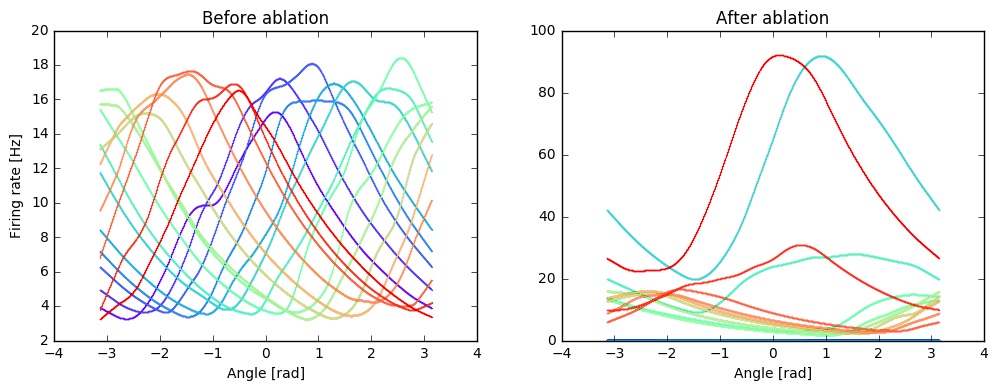

In [11]:
f, ax = plt.subplots(1,2)
f.set_figheight(4)
f.set_figwidth(12)
print(lowess[3].shape)

for neuron in range(N):
    ax[0].plot(lowess[neuron][:,0], lowess[neuron][:,1],".", markersize=0.5, c=col(neuron))
ax[0].set_xlabel("Angle [rad]")
ax[0].set_ylabel("Firing rate [Hz]")
ax[0].set_title("Before ablation")

for neuron in range(N):
    print(neuron+N)
    ax[1].plot(lowess[neuron+N][:,0], lowess[neuron+N][:,1],".", markersize=0.5, c=col(neuron))
ax[1].set_title("After ablation")
ax[1].set_xlabel("Angle [rad]")
#ax[1].set_ylabel("Firing rate [Hz]")

plt.show()

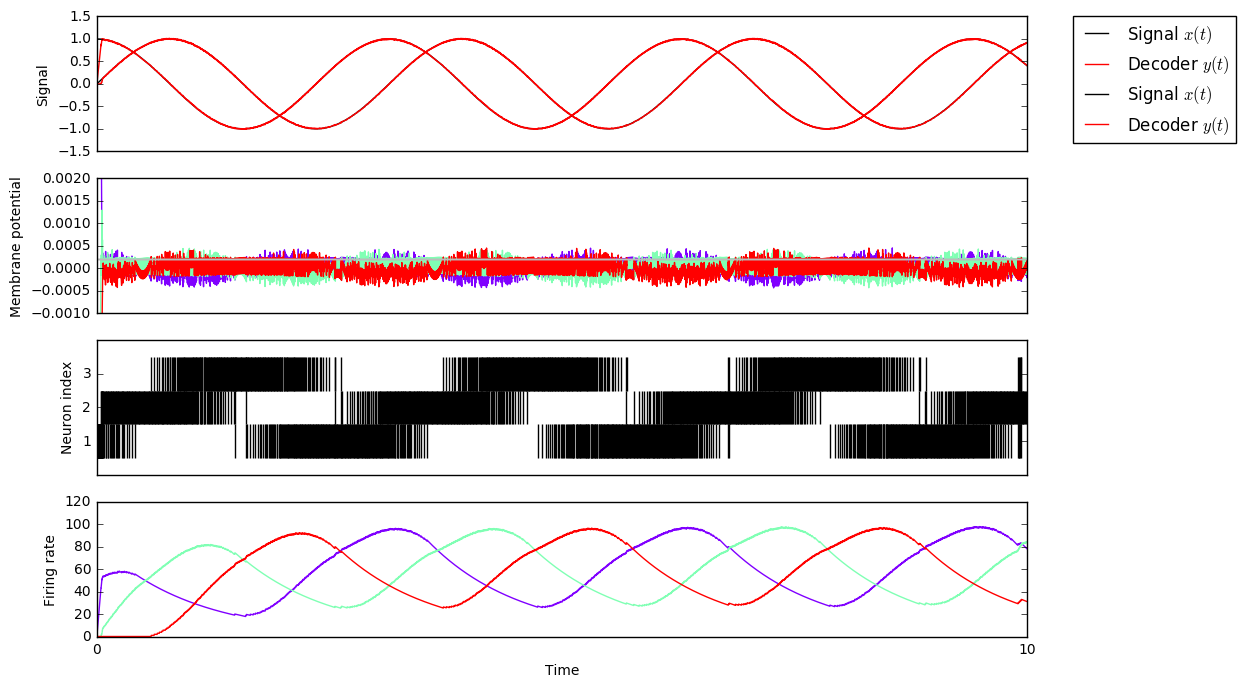

In [10]:
f, ax = plot_fig1()
plt.xlim([0, 10])
plt.show()


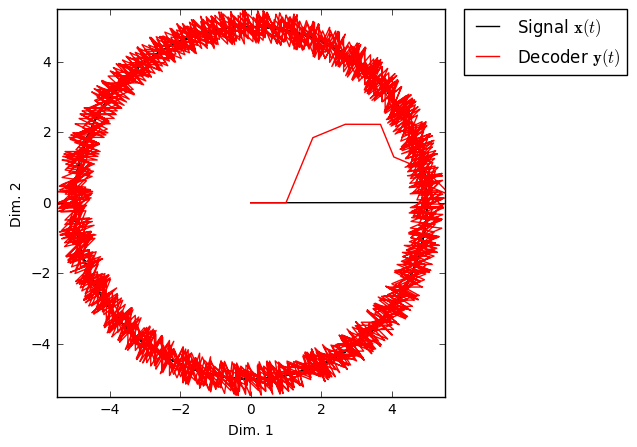

In [18]:
def plot_fig2():
    f = plt.figure(figsize=(5,5))
    plt.plot(x[0,:],x[1,:],'k-', label = 'Signal $\mathbf{x}(t)$')
    plt.plot(y[0,:],y[1,:],'r-', label ='Decoder $\mathbf{y}(t)$')
    return f

f = plot_fig2()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
rad=np.max(np.max(x))+0.1*np.max(np.max(x))
plt.xlim((-rad,rad))
plt.ylim((-rad,rad))
plt.xlabel("Dim. 1")
plt.ylabel("Dim. 2")
plt.show()

In [12]:
" Goes through different angles "
angs = np.arange(-np.pi,np.pi,np.pi/128)
rates  = []
steady = 5000
for angle in angs:
    #print("Current angle:",angle)
    V        = np.zeros((N,len(time)))    # Membrane potential
    y        = np.zeros((M,len(time)))    # Decoder
    o        = np.zeros((N,len(time)))    # Spikes
    rate     = np.zeros((N,len(time)))    # Firing rate
    x        = np.zeros((M,len(time))) 
    x[0,:]   = np.cos(angle)
    x[1,:]   = np.sin(angle)
    x[0,0]   = 0
    x[1,0]   = 0
    for i,t in enumerate(time[:-1]):
        step(i)
    #means.append(np.mean((x-y)**2))
    #rates.append(np.mean(rate[:,hns:], axis=1)) # based on ISI
    rates.append(np.sum(o[:,steady:], axis=1)/5)
    #print(rates[-1])
    
rates = np.array(rates)

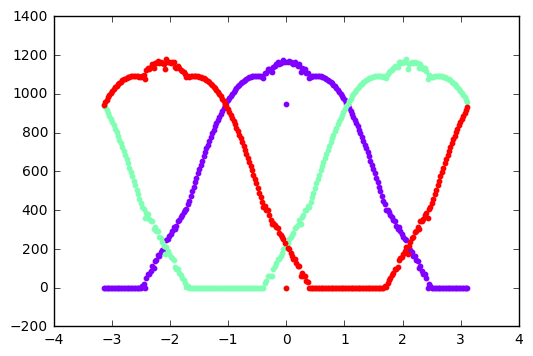

In [13]:
for neuron in range(N):
    plt.scatter(angs,rates[:,neuron],s=10, c=col(neuron),edgecolors=col(neuron))
#plt.xlim([-4*np.pi/64,4*np.pi/64])
plt.show()

NameError: name 'mus' is not defined

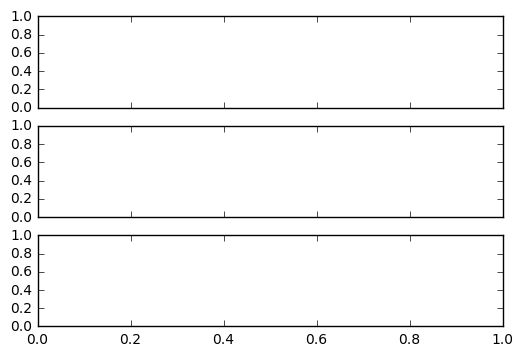

In [14]:
" Print/plot minimum error w.r.t. D "
f, axarr = plt.subplots(3, sharex=True)
axarr[0].semilogx(mus, means, '.-', color='#cc6600', label = '$<L(t)>$')
axarr[0].semilogx([minmu, minmu], [0.0, 1.0], 'r--')
axarr[0].legend()

axarr[1].semilogx(mus, np.mean(rates, axis=1), '.-', color='#0066cc', label = '$<r(t)>$')
axarr[1].semilogx(mus, a/np.asarray(mus), color='#cc66cc', label = '$1/\mu$')
axarr[1].set_ylim((0.0,30.0))
axarr[1].legend()

axarr[2].semilogx(mus, np.std(rates, axis=1), '.-', color='#0099cc', label = '$\sigma_r$')
axarr[2].legend()
plt.show()


In [21]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

# minimize
#     F = ((x-Dr).T).dot(x-Dr) ###x[1]^2 + 4x[2]^2 -32x[2] + 64

# subject to:
#      x[0] >= 0
#      x[1] >= 0
#      x[2] >= 0

# in matrix notation:
#     F = (1/2)*x.T*H*x + c*x + c0

# subject to:
#     Ax <= b

# where:
#     H = [[2, 0],
#          [0, 8]]

#     c = [0, -32]

#     c0 = 64

#     A = [[ 1, 1],
#          [-1, 2],
#          [-1, 0],
#          [0, -1],
#          [0,  1]]

#     b = [0,0,0]

D = np.array([[1., -0.5, -0.5],
              [0., np.sin(2*np.pi/3), -np.sin(2*np.pi/3)]])

x = np.array([])

A = np.eye(3)

b = np.array([0., 0., 0.])

x0 = np.random.randn(3)

def loss(r, sign=1.):
    error = x-np.dot(D, r)
    return sign * (np.dot(error,error))

def jac(r, sign=1.):
    return sign * 2. * (np.dot(D.T.dot(D), r) - np.dot(D.T, x))

cons = {'type':'ineq',
        'fun':lambda r: -np.dot(A,r),
        'jac':lambda r: -A}

opt = {'disp':False}

def solve():

    res_cons = optimize.minimize(loss, x0, jac=jac,constraints=cons,
                                 method='SLSQP', options=opt)

    res_uncons = optimize.minimize(loss, x0, jac=jac, method='SLSQP',
                                   options=opt)

    print('\nConstrained:')
    print(res_cons)

    print('\nUnconstrained:')
    print(res_uncons)

    r0, r1, r2 = res_cons['x']
    f = res_cons['fun']

    r0u, r1u, r2u = res_uncons['x']
    f_unc = res_uncons['fun']

In [22]:
solve()

NameError: name 'r' is not defined

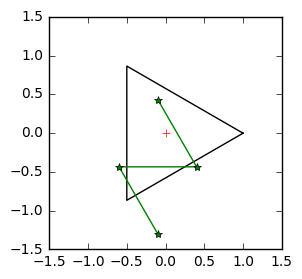

In [63]:
K = 3
x, y = np.array([np.cos(2*np.pi*i/K)for i in range(K+1)]), np.array([np.sin(2*np.pi*i/K)for i in range(K+1)])
plt.figure(figsize=(3,3))
plt.plot(x,y,'k-')
plt.plot(0,0,'r+')

rx, ry = [-0.1],[-1.3]
rx.append(rx[-1]+x[1])
ry.append(ry[-1]+y[1])
rx.append(rx[-1]+x[0])
ry.append(ry[-1]+y[0])
rx.append(rx[-1]+x[1])
ry.append(ry[-1]+y[1])
plt.plot(rx,ry,'g*-')

plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()